## Set-up environment

First, we install 🤗 Transformers, as well as 🤗 Datasets and Seqeval (the latter is useful for evaluation metrics such as F1 on sequence labeling tasks).

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install transformers[torch]
!pip install accelerate -U

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

IOB_DATA_PATH = "/content/drive/MyDrive/dataset/raw_data_finetune_layoumlv3_sep_7.zip"



# Copy and extract the dataset
!cd /content/
!rm -r data
!mkdir data
!cp "$IOB_DATA_PATH" data/dataset.zip
!cd data && unzip -q dataset
!cd ..

Mounted at /content/drive/
rm: cannot remove 'data': No such file or directory


## Load dataset

Next, we load a dataset from the 🤗 [hub](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3). This one is the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, a collection of annotated forms.

In [ ]:
from datasets import load_dataset, load_from_disk

# this dataset uses the new Image feature :)
# dataset = load_dataset("nielsr/funsd-layoutlmv3")
dataset = load_from_disk(f'/content/data')

As we can see, the dataset consists of 2 splits ("train" and "test"), and each example contains a list of words ("tokens") with corresponding boxes ("bboxes"), and the words are tagged ("ner_tags"). Each example also include the original image ("image").

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 24
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 3
    })
})

Let's check the features:

In [ ]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['E-VALUE', 'I-IGNORE', 'S-KEY', 'E-IGNORE', 'S-IGNORE', 'S-VALUE', 'I-VALUE', 'B-IGNORE', 'B-VALUE', 'B-TABLE', 'O', 'I-TABLE', 'E-TABLE'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

Note that you can directly see the example in a notebook (as the "image" column is of type [Image](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Image)).

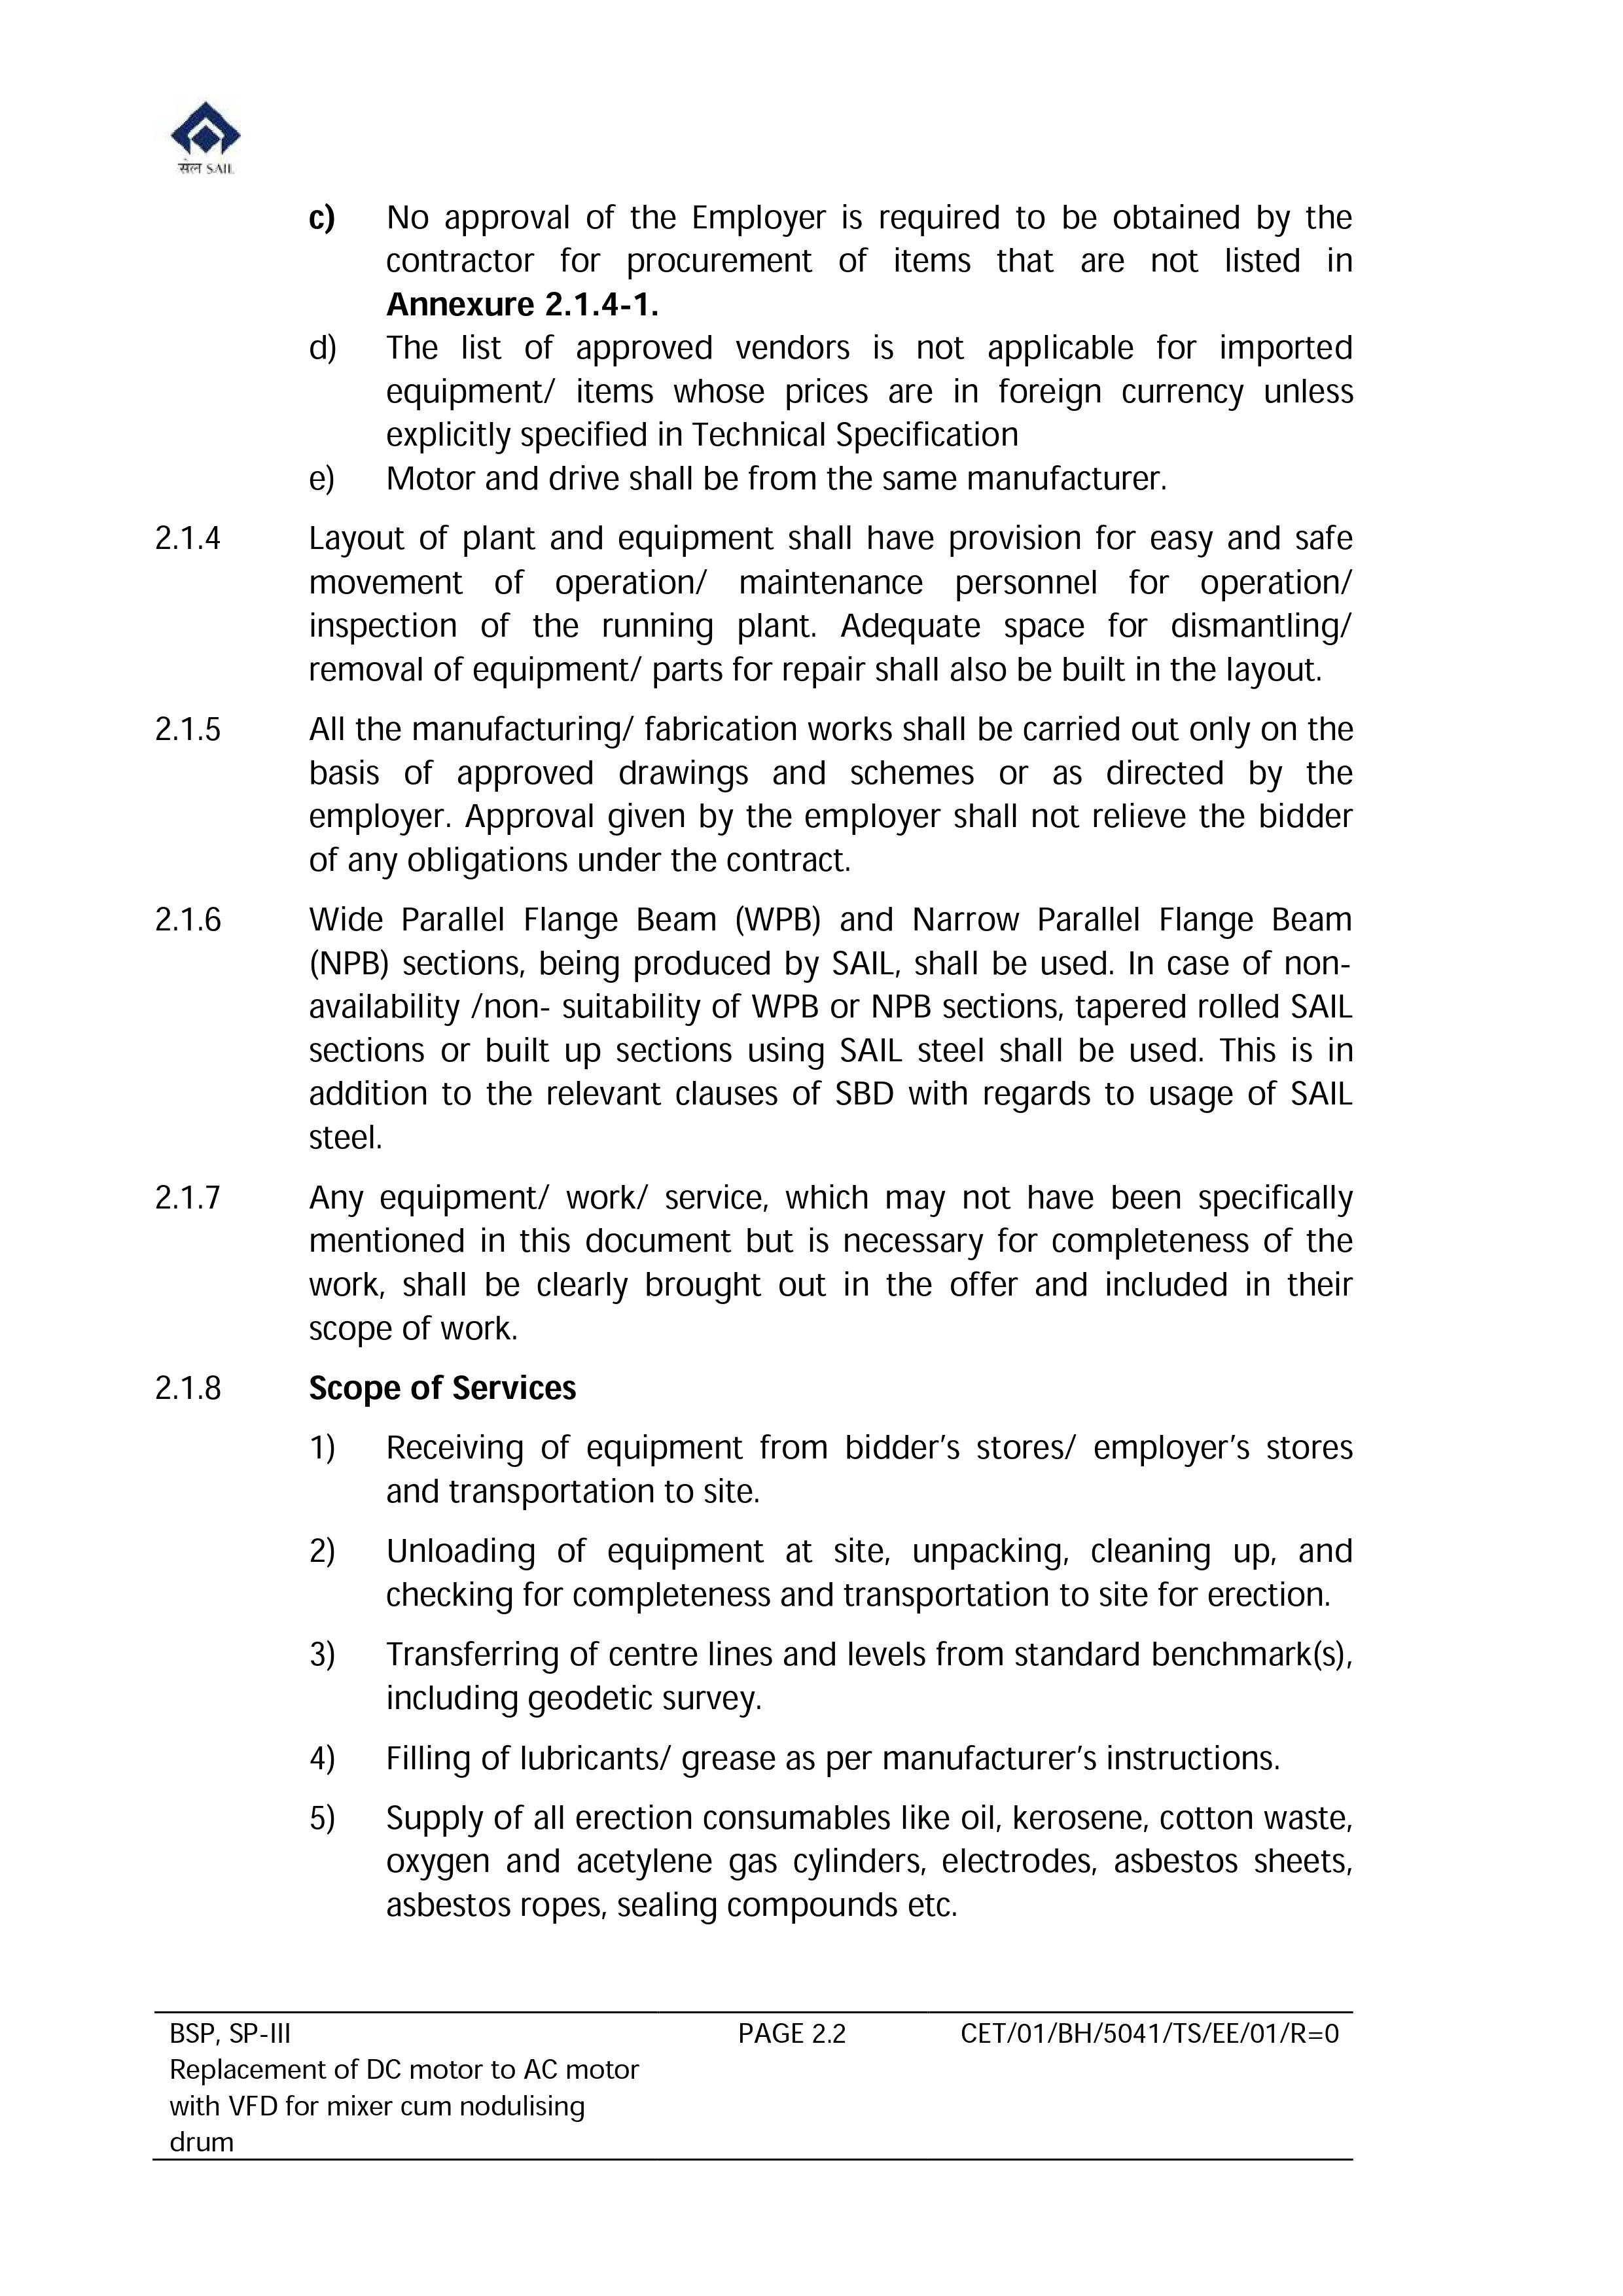

In [ ]:
example = dataset["train"][0]
example["image"]

In [ ]:
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['HGT', 'SAIL', 'c)', 'No', 'approval', 'of', 'the', 'Employer', 'is', 'required', 'to', 'be', 'obtained', 'by', 'the', 'contractor', 'for', 'procurement', 'of', 'items', 'that', 'are', 'not', 'listed', 'in', 'Annexure', '2.1.4-1.', 'd)', 'The', 'list', 'of', 'approved', 'vendors', 'is', 'not', 'applicable', 'for', 'imported', 'equipment/', 'items', 'whose', 'prices', 'are', 'in', 'foreign', 'currency', 'unless', 'explicitly', 'specified', 'in', 'Technical', 'Specification', 'e)', 'Motor', 'and', 'drive', 'shall', 'be', 'from', 'the', 'same', 'manufacturer.', '2.1.4', 'Layout', 'of', 'plant', 'and', 'equipment', 'shall', 'have', 'provision', 'for', 'easy', 'and', 'safe', 'movement', 'of', 'operation/', 'maintenance', 'personnel', 'for', 'operation/', 'inspection', 'of', 'the', 'running', 'plant.', 'Adequate', 'space', 'for', 'dismantling/', 'removal', 'of', 'equipment/', 'parts', 'for', 'repair', 'shall', 'also', 'be', 'built', 'in', 'the', 'layout.', '2.1.5', 'All', 'the', 'manufactur

## Prepare dataset

Next, we prepare the dataset for the model. This can be done very easily using `LayoutLMv3Processor`, which internally wraps a `LayoutLMv3FeatureExtractor` (for the image modality) and a `LayoutLMv3Tokenizer` (for the text modality) into one.

Basically, the processor does the following internally:
* the feature extractor is used to resize + normalize each document image into `pixel_values`
* the tokenizer is used to turn the words, boxes and NER tags into token-level `input_ids`, `attention_mask` and `labels`.

The processor simply returns a dictionary that contains all these keys.

In [ ]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

We'll first create `id2label` and label2id mappings, useful for inference. Note that `LayoutLMv3ForTokenClassification` (the model we'll use later on) will simply output an integer index for a particular class (for each token), so we still need to map it to an actual class name.

In [ ]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [ ]:
print(label_list)

['E-VALUE', 'I-IGNORE', 'S-KEY', 'E-IGNORE', 'S-IGNORE', 'S-VALUE', 'I-VALUE', 'B-IGNORE', 'B-VALUE', 'B-TABLE', 'O', 'I-TABLE', 'E-TABLE']


In [ ]:
print(id2label)

{0: 'E-VALUE', 1: 'I-IGNORE', 2: 'S-KEY', 3: 'E-IGNORE', 4: 'S-IGNORE', 5: 'S-VALUE', 6: 'I-VALUE', 7: 'B-IGNORE', 8: 'B-VALUE', 9: 'B-TABLE', 10: 'O', 11: 'I-TABLE', 12: 'E-TABLE'}


Next, we'll define a function which we can apply on the entire dataset.

In [ ]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [ ]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 24
})

In [ ]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

"<s> HGT SAIL c) No approval of the Employer is required to be obtained by the contractor for procurement of items that are not listed in Annexure 2.1.4-1. d) The list of approved vendors is not applicable for imported equipment/ items whose prices are in foreign currency unless explicitly specified in Technical Specification e) Motor and drive shall be from the same manufacturer. 2.1.4 Layout of plant and equipment shall have provision for easy and safe movement of operation/ maintenance personnel for operation/ inspection of the running plant. Adequate space for dismantling/ removal of equipment/ parts for repair shall also be built in the layout. 2.1.5 All the manufacturing/fabrication works shall be carried out only on the basis of approved drawings and schemes or as directed by the employer. Approval given by the employer shall not relieve the bidder of any obligations under the contract. 2.1.6 Wide Parallel Flange Beam (WPB) and Narrow Parallel Flange Beam (NPB) sections, being p

Next, we set the format to PyTorch.

In [ ]:
train_dataset.set_format("torch")

Let's verify that everything was created properly:

In [ ]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [ ]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 3
})

In [ ]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> #M SAII 1.4.3.2 Shutdown activities during 7 days annual/planned shutdown shall be as shown below: SI. Activity Day 1 of Day 2 - 5 Day 6-7 Shut No Shutdown of down Shutdown 1 Preliminary shut Shop / down to take out planned major portion of shutdown existing MND motor. 2 Chipping/Dismantlin Civil g of existing Motor activities foundation as per during requirement to shutdown match the shaft height of the gear box. Drilling & grouting of dowels & RCC concreting with epoxy/non-shrink grouts to integrate the old concrete suiting to incoming load of proposed motor. Necessary curing 3 Inline Installation of Motor new motor installation, Cable termination & cable Drives System termination, Interfacing etc. drive interfacing etc 4 Preliminary Shop / shutdown to take out planned existing transformer shutdown by disconnecting cable etc. Installation of new transformer in existing transformer BSP, SP-III PAGE 1.3 CET/01/BH/5041/TS/EE/01/R=0 Replacement of DC motor to AC motor with VFD for m

In [ ]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 H 7
GT -100
 SA 3
IL -100
 c 2
) -100
 No 8
 approval 6
 of 6
 the 6
 Employ 6
er -100
 is 6
 required 6
 to 6
 be 6
 obtained 6
 by 6
 the 6
 contractor 6
 for 6
 procurement 6
 of 6
 items 6
 that 6
 are 6
 not 6
 listed 6
 in 6
 Annex 6
ure -100
 2 0
. -100
1 -100
. -100
4 -100
- -100
1 -100
. -100
 d 2
) -100
 The 8
 list 6
 of 6
 approved 6
 vendors 6
 is 6
 not 6
 applicable 6
 for 6
 imported 6
 equipment 6
/ -100
 items 6
 whose 6
 prices 6
 are 6
 in 6
 foreign 6
 currency 6
 unless 6
 explicitly 6
 specified 6
 in 6
 Technical 6
 Spec 0
ification -100
 e 5
) -100
 Motor 8
 and 6
 drive 6
 shall 6
 be 6
 from 6
 the 6
 same 6
 manufacturer 0
. -100
 2 2
. -100
1 -100
. -100
4 -100
 Layout 8
 of 6
 plant 6
 and 6
 equipment 6
 shall 6
 have 6
 provision 6
 for 6
 easy 6
 and 6
 safe 6
 movement 6
 of 6
 operation 6
/ -100
 maintenance 6
 personnel 6
 for 6
 operation 6
/ -100
 inspection 6
 of 6
 the 6
 running 6
 plant 6
. -100
 Ad 6
equ -100
ate -100
 space 6
 for 6

## Define metrics

Next, we define a `compute_metrics` function, which is used by the Trainer to ... compute metrics.

This function should take a named tuple as input, and return a dictionary as output as stated in the [docs](https://huggingface.co/docs/transformers/main_classes/trainer).

In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-22-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [ ]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Define the model

Next we define the model: this is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [ ]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define TrainingArguments + Trainer

Next we define the `TrainingArguments`, which define all hyperparameters related to training. Note that there is a huge amount of parameters to tweak, check the [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) for more info.

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="layoutmlv3_thursday_sep7_v5",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

We can now instantiate a Trainer, with the model and args defined above. We also provide our datasets, as well as a "default data collator" - which will batch the examples using `torch.stack`. We also provide our `compute_metrics` function defined above.

In [ ]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

## Train the model

Let's train!

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:895: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:895: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.13724496746063233, metrics={'train_runtime': 494.2478, 'train_samples_per_second': 4.047, 'train_steps_per_second': 2.023, 'total_flos': 530867632128000.0, 'train_loss': 0.13724496746063233, 'epoch': 83.33})

## Evaluate the model

NOTE: we end up with an F1 score of about 90%. Here's what I got on a typical run:
```
Step	Training Loss	Val Loss	Precision	Recall	F1	Accuracy
100	  No log	  0.716025	0.752040	0.824143	0.786442	0.780459
200	  No log	  0.584986	0.828558	0.876304	0.851762	0.801973
300	  No log	  0.525926	0.859583	0.900149	0.879398	0.833947
400	  No log	  0.492821	0.881413	0.904620	0.892866	0.854630
500	  0.561200	0.528126	0.858382	0.885246	0.871607	0.852490
600	  0.561200	0.547107	0.888023	0.906110	0.896976	0.847973
700	  0.561200	0.555438	0.887338	0.915549	0.901222	0.859384
800	  0.561200	0.582942	0.881471	0.905117	0.893137	0.854749
900	  0.561200	0.599762	0.891051	0.910084	0.900467	0.852015
1000	0.133400	0.608207	0.887222	0.910581	0.898750	0.847855
````

However, this score cannot be directly compared to LayoutLM and LayoutLMv2, as LayoutLMv3 employs so-called **segment position embeddings** (inspired by [StructuralLM](https://arxiv.org/abs/2105.11210)). This means that several tokens that belong to the same "segment" (let's say, an address) get the same bounding box coordinates, and in return the same 2D position embeddings.

This is also mentioned in the paper:
>  Note that LayoutLMv3 and StructuralLM use segment-level layout positions, while the other works use word-level layout positions. The use of segment-level positions may benefit the semantic entity labeling task on FUNSD [25], so the two types of work are not directly comparable.

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:895: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.14156574010849,
 'eval_precision': 0.5517241379310345,
 'eval_recall': 0.9411764705882353,
 'eval_f1': 0.6956521739130435,
 'eval_accuracy': 0.9822380106571936,
 'eval_runtime': 0.4074,
 'eval_samples_per_second': 7.363,
 'eval_steps_per_second': 4.909,
 'epoch': 83.33}

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
pip install --upgrade huggingface_hub

In [ ]:
# trainer.save_model('')
# trainer.save_model("dwitidibyajyoti/layoutmlv3_train_v5")
trainer.push_to_hub()


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

'https://huggingface.co/dwitidibyajyoti/layoutmlv3_thursday_sep7_v5/tree/main/'

In [ ]:
!sudo zip layoutmlv3_sunday_sep3_v5.1.zip /content/layoutmlv3_sunday_sep3_v5/

updating: content/layoutmlv3_sunday_sep3_v5/ (stored 0%)


## Inference

You can load the model for inference as follows:

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("dwitidibyajyoti/layoutmlv3_thursday_sep7_v5")
# https://huggingface.co/dwitidibyajyoti/layoutmlv3_sunday_sep3_v5/tree/main/

Let's take an example of the training dataset to show inference.

In [ ]:
example = dataset["test"][0]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])


We first prepare it for the model using the processor.

In [ ]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
print(boxes)
print(words)
word_labels = example["ner_tags"]
print(word_labels)

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

[[854, 71, 869, 75], [871, 71, 888, 76], [168, 97, 223, 108], [262, 97, 351, 109], [358, 97, 435, 109], [442, 97, 499, 112], [507, 97, 516, 108], [524, 97, 563, 112], [570, 97, 710, 111], [716, 97, 804, 109], [811, 97, 850, 109], [858, 98, 879, 109], [887, 100, 905, 109], [262, 117, 318, 128], [325, 116, 382, 128], [271, 143, 292, 154], [335, 143, 407, 158], [593, 143, 629, 157], [636, 143, 643, 154], [652, 143, 673, 154], [721, 143, 756, 158], [762, 143, 773, 154], [780, 149, 787, 152], [794, 143, 804, 154], [838, 143, 874, 158], [880, 143, 910, 154], [917, 143, 960, 154], [271, 162, 298, 173], [584, 162, 681, 173], [752, 161, 773, 173], [872, 162, 925, 173], [714, 181, 810, 192], [307, 201, 313, 211], [361, 200, 460, 215], [514, 200, 552, 212], [571, 200, 616, 214], [622, 200, 629, 211], [361, 219, 409, 231], [429, 220, 447, 230], [466, 219, 503, 231], [523, 220, 552, 231], [571, 219, 641, 233], [362, 238, 412, 252], [441, 238, 505, 252], [533, 238, 553, 249], [570, 238, 657, 249], [

Next, we do a forward pass. We use torch.no_grad() as we don't require gradient computation.

In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:895: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


The model outputs logits of shape (batch_size, seq_len, num_labels).

In [ ]:
logits = outputs.logits
logits.shape

torch.Size([1, 239, 13])

We take the highest score for each token, using argmax. This serves as the predicted label for each token.

In [ ]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[6, 7, 7, 3, 3, 2, 2, 2, 2, 2, 2, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 6]


Let's compare this to the ground truth: note that many labels are -100, as we're only labeling the first subword token of each word.

NOTE: at "true inference" time, you don't have access to labels, see the latest section of this notebook how you can use `offset_mapping` in that case.

In [ ]:
labels = encoding.labels.squeeze().tolist()
print(labels)

[-100, 7, -100, 3, -100, 2, -100, -100, -100, -100, -100, -100, 8, 6, 6, 6, 6, 6, -100, -100, 6, 6, 6, 6, 6, 0, -100, 9, -100, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, -100, -100, 11, 11, 11, 11, 11, 11, 11, 11, -100, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, -100, 11, -100, 11, 11, -100, -100, -100, -100, -100, -100, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, -100, 11, -100, 11, 11, -100, 11, 11, -100, 11, 11, -100, 11, -100, -100, 11, 11, -100, -100, -100, -100, -100, -100, 11, -100, 11, 11, 11, 11, 11, 11, -100, 11, 11, 11, 11, 11, 11, -100, 11, -100, -100, 11, 11, 11, -100, 11, 11, 11, 11, 11, 11, -100, 11, 11, 11, 11, 11, -100, 11, 11, -100, 11, -100, 11, -100, 11, 11, -100, 11, 11, 11, -100, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, -100, 11, 11, -100, 11, 11, 11, 11, 11, 11, 12, 7, -100, -100, 1, -100, -100, 1, 1, -100, -100, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -1

So let's only compare predictions and labels at positions where the label isn't -100. We also want to have the bounding boxes of these (unnormalized):

In [ ]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

['B-IGNORE', 'E-IGNORE', 'S-KEY', 'B-VALUE', 'I-VALUE', 'I-VALUE', 'I-VALUE', 'I-VALUE', 'I-VALUE', 'I-VALUE', 'I-VALUE', 'I-VALUE', 'I-VALUE', 'I-VALUE', 'E-VALUE', 'B-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE', 'I-TABLE'

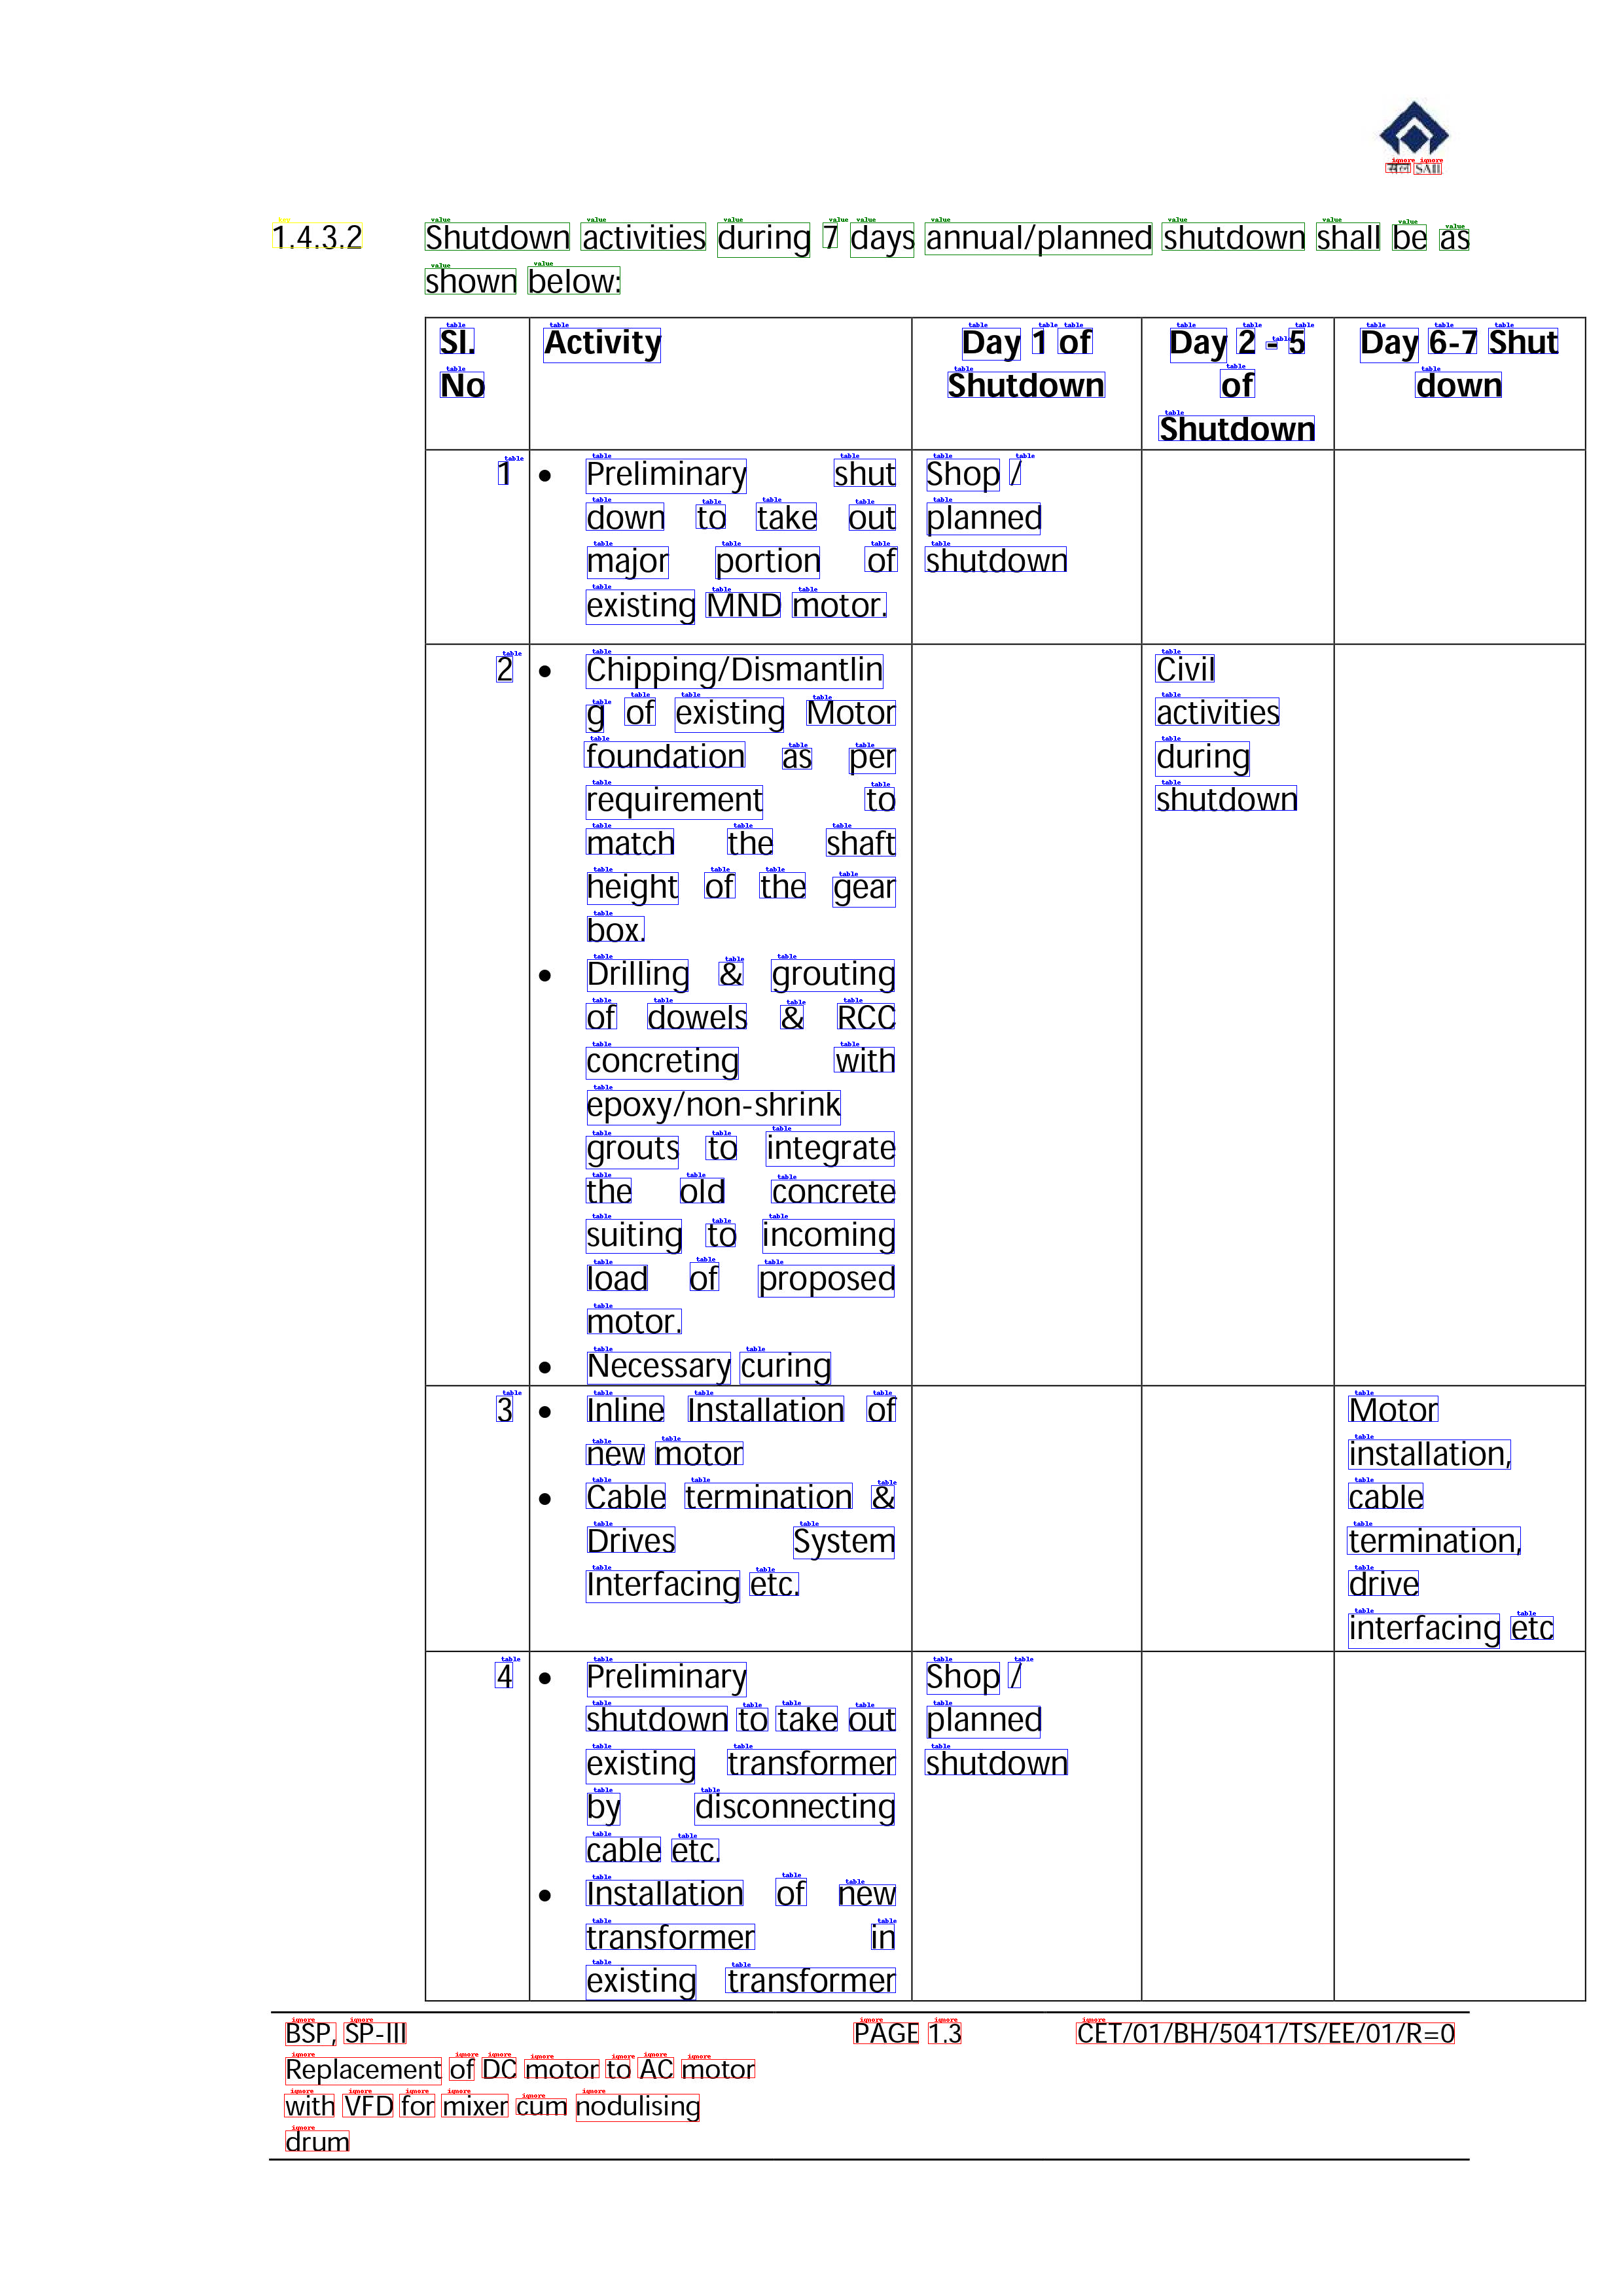

In [ ]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

# label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
label2color = {
    "table": "blue",
    "value": "green",
    "ignore": "red",
    "key": "yellow",
    "column":"orange",'other':'violet'}



print(true_predictions)
for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

Compare this to the ground truth:

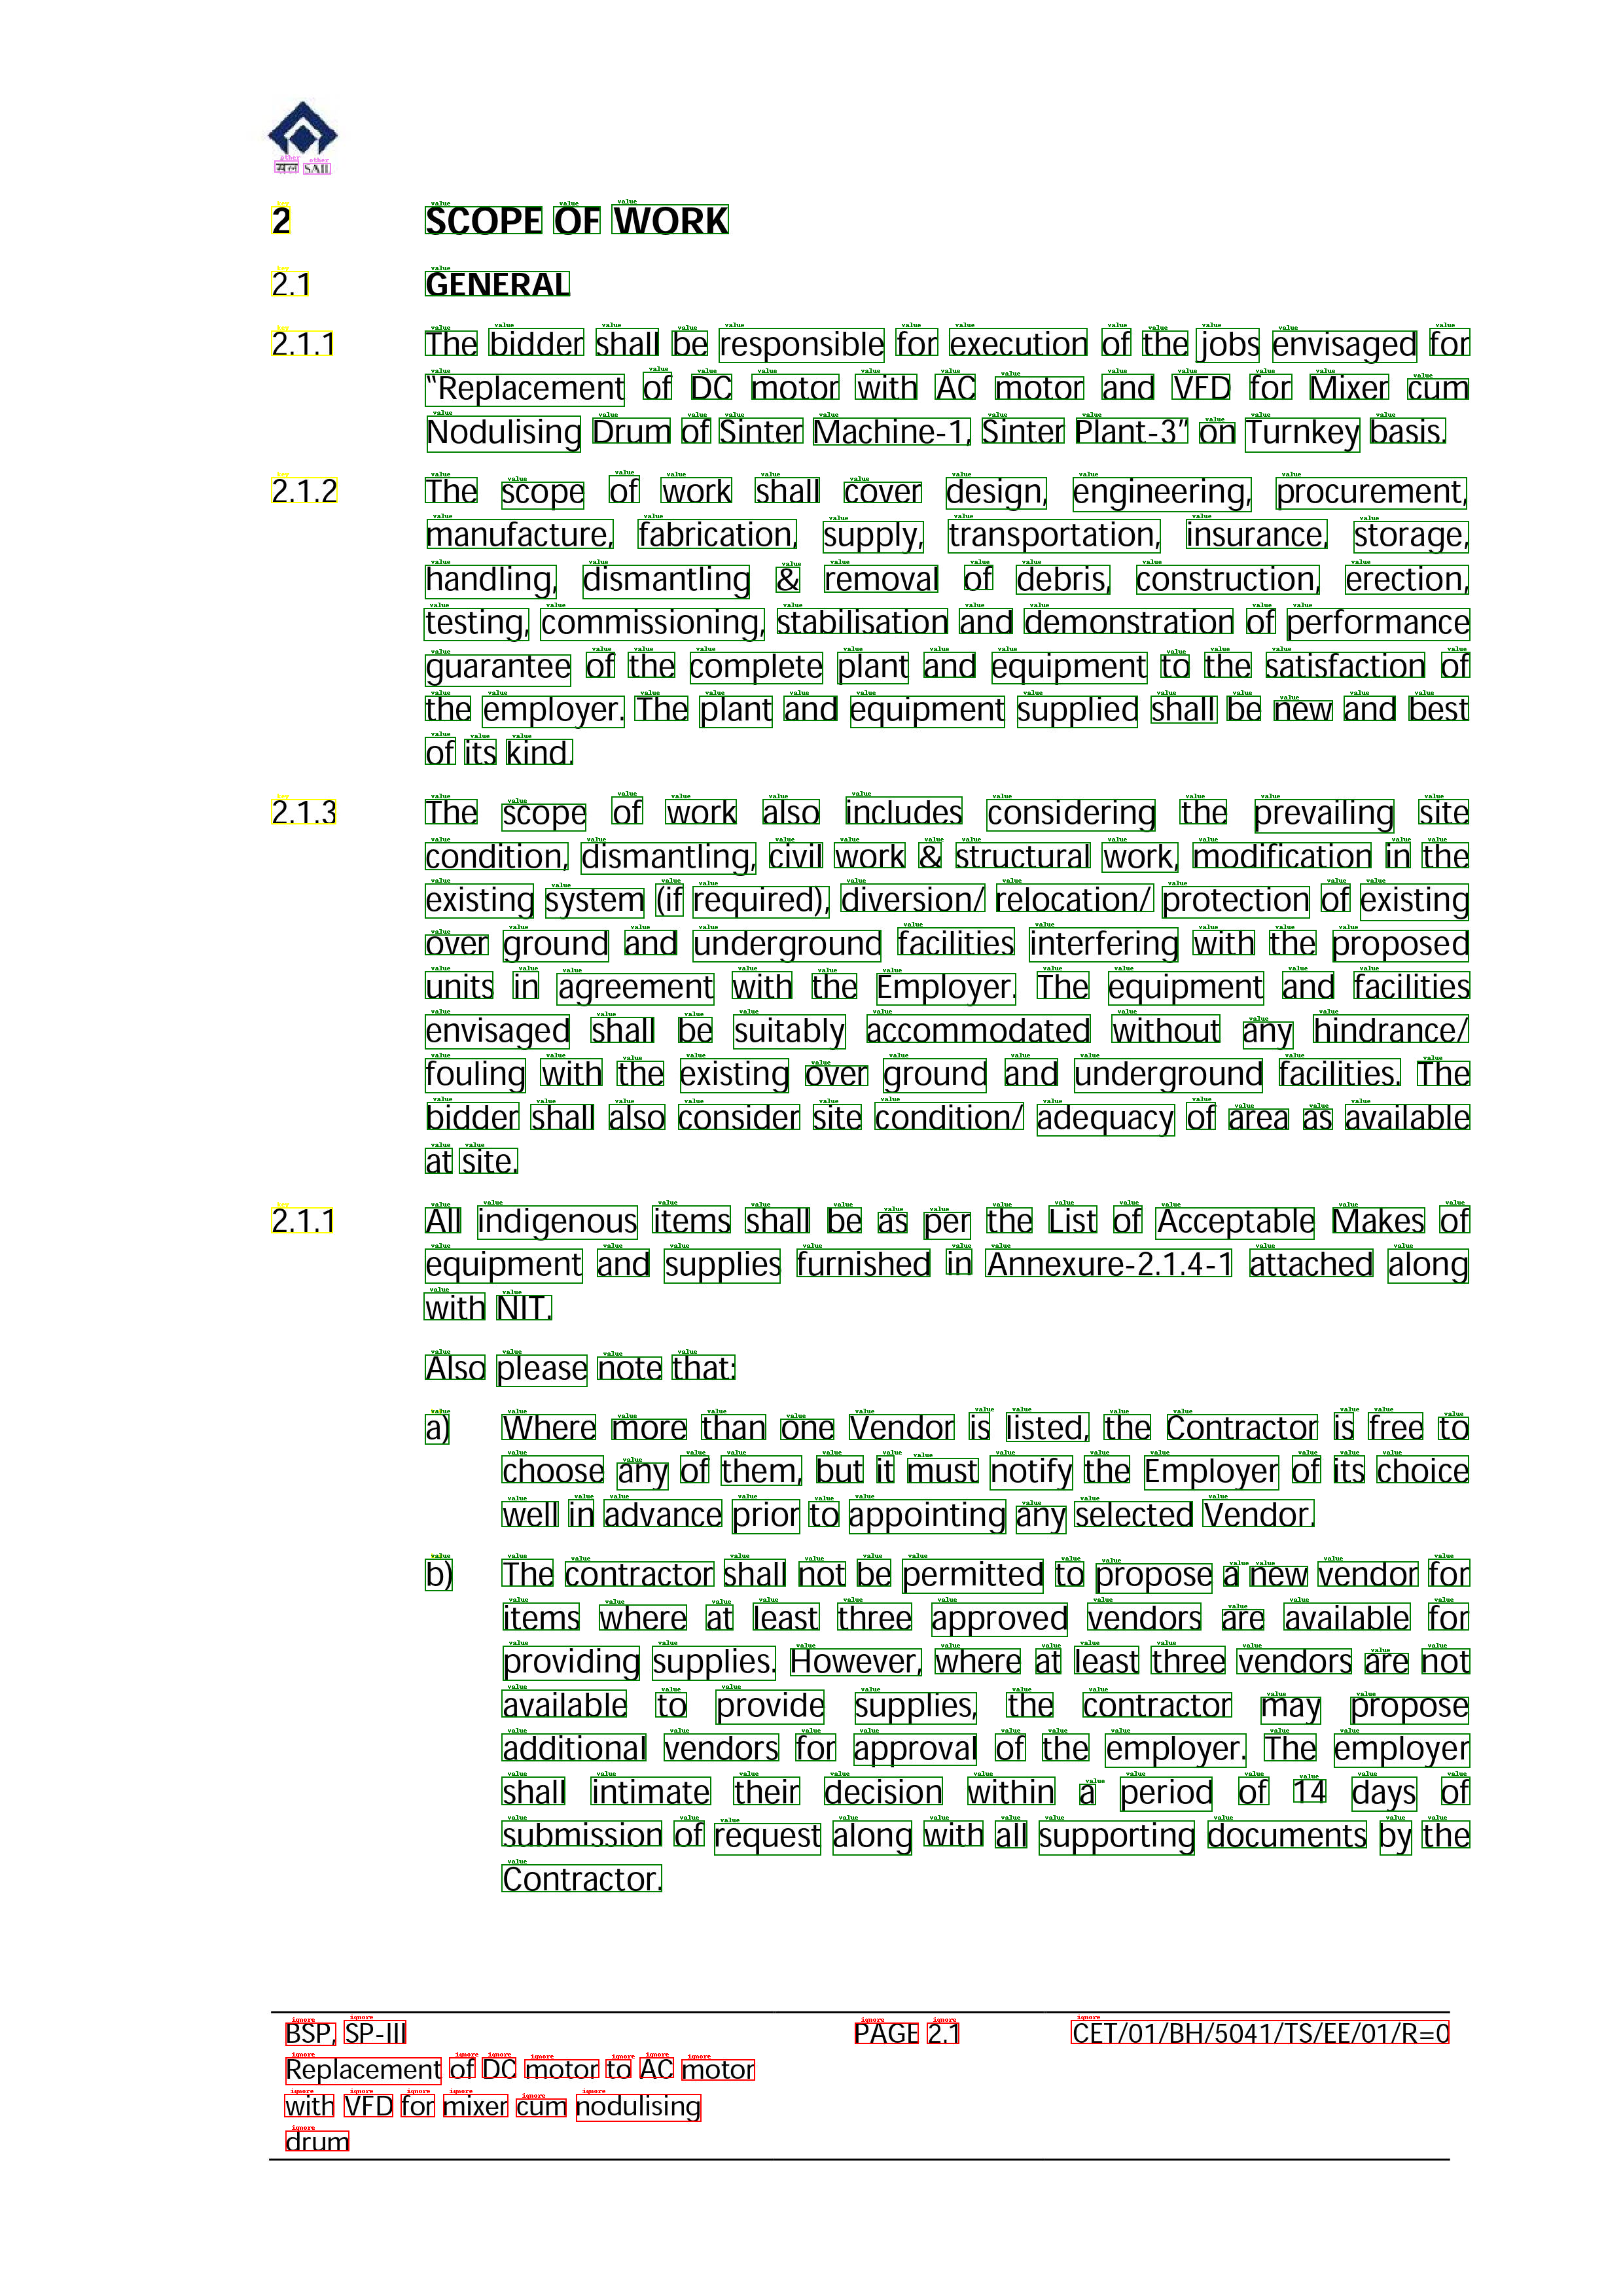

In [ ]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image

## Note: inference when you don't have labels

The code above used the `labels` to determine which tokens were at the start of a particular word or not. Of course, at inference time, you don't have access to any labels. In that case, you can leverage the `offset_mapping` returned by the tokenizer. I do have a notebook for that (for LayoutLMv2, but it's equivalent for LayoutLMv3) [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv2/FUNSD/True_inference_with_LayoutLMv2ForTokenClassification_%2B_Gradio_demo.ipynb).